<a href="https://www.kaggle.com/code/angelikaboltneva/car-prediction-randomised-search?scriptVersionId=132347886" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Нам предстоит решить задачу регрессии.
Этапы нашего исследования включают в себя:
загрузка и ознакомление с данными;
анализ и предварительная обработка данных;
анализ имеющихся признаков и разработка синтетических признаков;
подбор гиперпараметров и обучение модели;
итоговая оценка качества предсказания лучшей модели;
анализ важности ее признаков.


# Предобработка и исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import catboost
import optuna

In [2]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [3]:
train = pd.read_csv('/kaggle/input/car-price-predictions/train.csv')
train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


In [4]:
test = pd.read_csv('/kaggle/input/car-price-predictions/test.csv')
test.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


In [7]:
train.dtypes.to_frame().transpose()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,int64,object,object,object,object,object,object,object,float64,float64,object,object,object,int64,object


Признаки в данных представлены категориальными (object) и числовыми (int64, float64) признаками.

In [8]:
# Преобразуем признак saledate в формат date_time, далее создадим два синтетических признака разделив дату на год и месяц
#datetime
train['sale_date'] = pd.to_datetime(train['saledate'],utc=True).dt.tz_convert(None)
train['sale_date'].head()

0   2015-06-01 19:30:00
1   2015-02-24 18:00:00
2   2015-06-09 19:30:00
3   2015-06-16 20:00:00
4   2015-02-02 20:00:00
Name: sale_date, dtype: datetime64[ns]

In [9]:
#тестовая
test['sale_date'] = pd.to_datetime(test['saledate'], utc=True).dt.tz_convert(None)
test['sale_date'].head()

0   2015-01-13 20:30:00
1   2015-02-26 17:00:00
2   2015-02-23 17:30:00
3   2015-03-05 18:00:00
4   2015-06-02 20:30:00
Name: sale_date, dtype: datetime64[ns]

In [10]:
#Оставим только год и месяц
test['sale_year'] = test['sale_date'].dt.year
test['sale_month'] = test['sale_date'].dt.month
test.head(1)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,sale_date,sale_year,sale_month
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST),2015-01-13 20:30:00,2015,1


In [11]:
#Оставим только год и месяц
train['sale_year'] = train['sale_date'].dt.year
train['sale_month'] =train['sale_date'].dt.month
train.head(1)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,sale_date,sale_year,sale_month
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT),2015-06-01 19:30:00,2015,6


In [12]:
# удалим дублирующие признаки saledate
train = train.drop(['saledate','sale_date'], axis=1)
train.head(1)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,sale_year,sale_month
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,2015,6


In [13]:
# удалим дублирующие признаки saledate
test = test.drop(['saledate','sale_date'], axis=1)
test.head(1)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sale_year,sale_month
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,2015,1


In [14]:
# удалим признак vin, так как он неинформативен
train = train.drop('vin', axis = 1)
train.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,sale_year,sale_month
0,2011,Ford,Edge,SEL,suv,automatic,md,4.2,111041.0,black,black,santander consumer,12500,2015,6
1,2014,Ford,Fusion,SE,Sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015,2
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015,6
3,2003,HUMMER,H2,Base,suv,automatic,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015,6
4,2007,Ford,Fusion,SEL,Sedan,automatic,md,2.0,127709.0,black,black,purple heart,1300,2015,2


In [15]:
test = test.drop('vin', axis = 1)

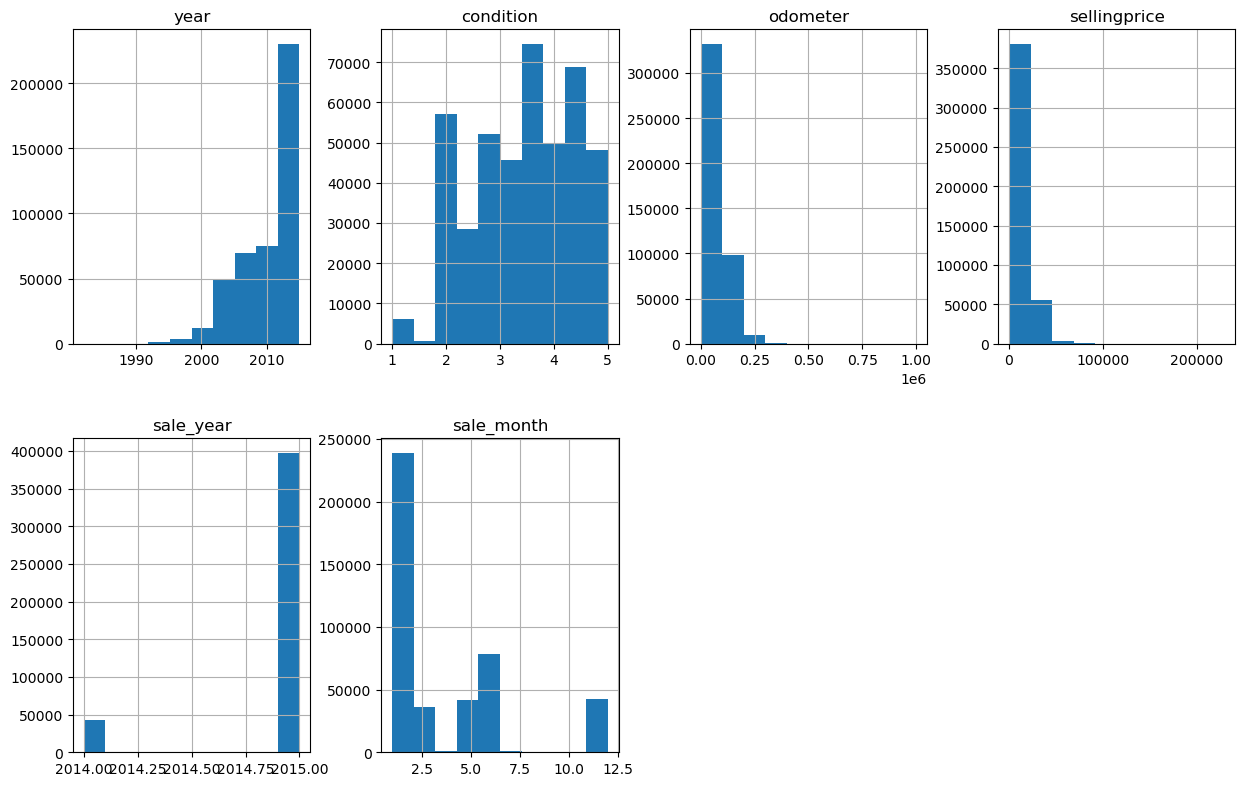

In [16]:
# Оценим визуально признаки, их распределение
train.select_dtypes(exclude=['object']).hist(layout=(4,4),figsize=(15, 20));

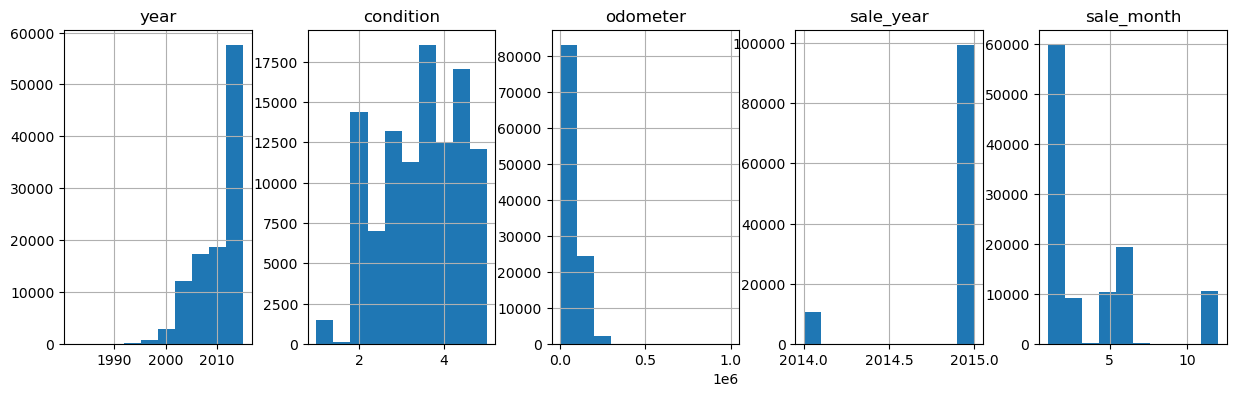

In [17]:
test.select_dtypes(exclude=['object']).hist(layout=(4,5),figsize=(15, 20));

Разпределение значение в обеих выборках сопоставимо друг с другом.

- в признаке year имееются очень старые автомибили, нужно оценить это подробнее (количество, выбросы?, коллекционные модели?)
- признак condition распределен нормально,значения от 1 до 5
- признак odometer нужно изучить на наличие аномалий
- sellingprice нужно изучить на наличие аномалий
- sale_month, sale_year в обработке и анализе не нуждаются

**Пропуски**

In [18]:
def pass_value_barh(data):
    try:
        ((data.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -0, legend = False, fontsize = 16, 
                  xticks=[i/10 for i in range(0, 1000, 50)])
            .set_title('Количество пропущенных значений' + "\n", fontsize = 22, color = 'Black')    
        );    
    except:
        print('пропусков не осталось')

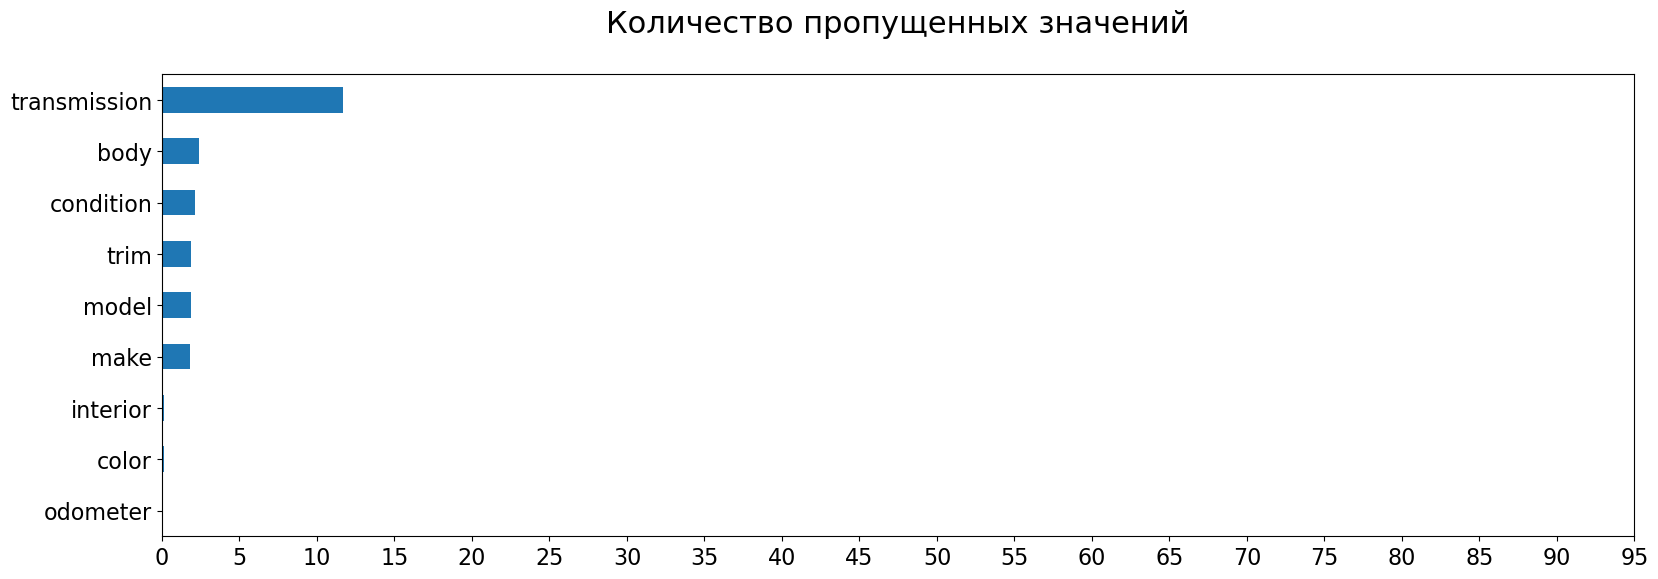

In [19]:
pass_value_barh(train)

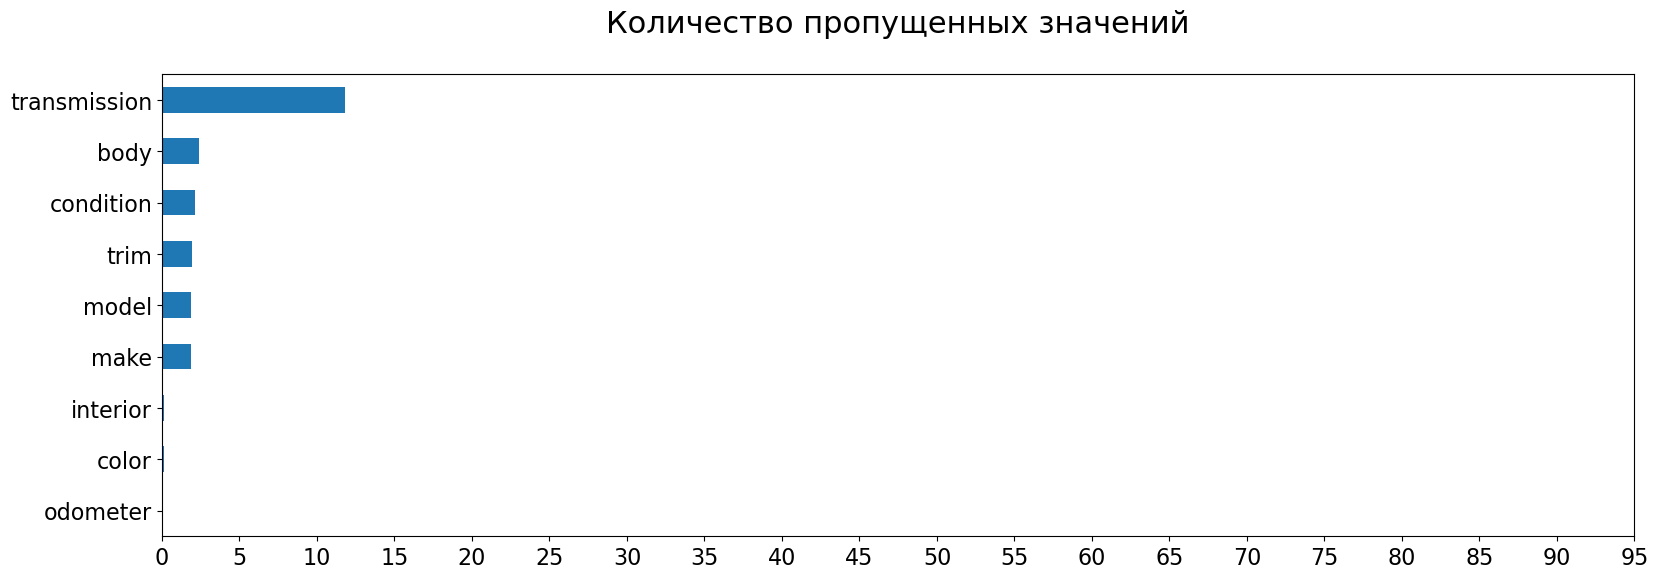

In [20]:
pass_value_barh(test)

Пропуски в обоих датасетах имеются в одинаковых признаках в соразмерном количестве.
Пропуски имеются как в категориальных так и в числовых признаках.

Заполним пропуски в числовых признаках нереальным числом чтобы модель могла это заметить, а в категориальных признаках заполним заглушкой "no_info".

Выделим из признаков категориальные признаки, это удобнее сделать в самом начале, чтобы анализировать и визуализировать отдельно числовые и отдельно категориальные признаки.

In [21]:
# Подготовим категориальные признаки для catboost
cat_features = list(train.select_dtypes(include='object').columns)
cat_features

['make',
 'model',
 'trim',
 'body',
 'transmission',
 'state',
 'color',
 'interior',
 'seller']

In [22]:
train[cat_features]=train[cat_features].fillna('no_info')
train.isna().sum()

year               0
make               0
model              0
trim               0
body               0
transmission       0
state              0
condition       9405
odometer          69
color              0
interior           0
seller             0
sellingprice       0
sale_year          0
sale_month         0
dtype: int64

In [23]:
test[cat_features]=test[cat_features].fillna('no_info')
test.isna().sum()

year               0
make               0
model              0
trim               0
body               0
transmission       0
state              0
condition       2379
odometer          19
color              0
interior           0
seller             0
sale_year          0
sale_month         0
dtype: int64

**sellingprice**

In [24]:
# проанализируем признак sellingprice
train['sellingprice'].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
sellingprice,440236.0,13592.209588,9751.479098,1.0,6900.0,12100.0,18200.0,230000.0


для стоимости такой разбег по максимальной стоимости вполне допустим. Посмотрим на самые дешевые объекты

In [25]:
train['sellingprice'].quantile([.01, .02,.1,.50]).to_frame().transpose()


,0.01,0.02,0.10,0.50
sellingprice,500.0,700.0,2700.0,12100.0


In [26]:
# посмотрим на объекты 2 квантиля
train.loc[(train['sellingprice']<=700), ['year','condition','odometer']].mean().to_frame()

,0
year,2000.298489
condition,1.871080
odometer,165823.042642


In [27]:
train.loc[train['sellingprice']<0].shape[0]

0

Общая картира дешевых объектов не противоречит логике:
- представлены старые автомобили, плохого состояния и с большим пробегом
- объекты с отрицательным значением стоимости отсутствуют

**condition**

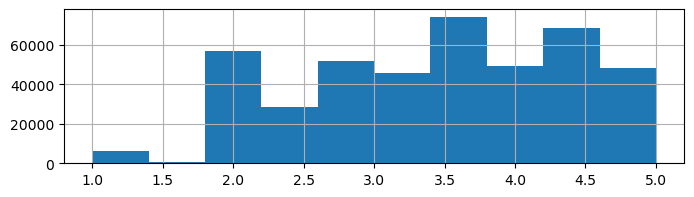

In [28]:
train['condition'].hist(figsize=(8,2));

Видим, что из всех числовых признаков пропуски имеются лишь в двух  'condition' и 'odometer'. Вероятнее всего эти признаки сильно зависят друг от друга, заполним признак condition исходя из пробега автомобиля.

In [29]:
train.loc[train['odometer']<30000, 'condition'].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
condition,119019.0,4.006383,0.81693,1.0,3.7,4.2,4.6,5.0


In [30]:
train.loc[(train['odometer']<30000) & (train['condition'].isna()), 'condition'].shape[0]

640

In [31]:
# заполним пропуски в признаке condition для объектов с пробегом менее 30 тыс средним значение равным 4
train.loc[(train['odometer']<30000) & (train['condition'].isna()), 'condition'] = train.loc[
    (train['odometer']<30000) & (train['condition'].isna()), 'condition'].fillna(4)

In [32]:
test.loc[(test['odometer']<30000) & (test['condition'].isna()), 'condition'] = test.loc[
    (test['odometer']<30000) & (test['condition'].isna()), 'condition'].fillna(4)

In [33]:
train.loc[(train['odometer']<30000) & (train['condition'].isna()), 'condition'].shape[0]

0

,count,mean,std,min,25%,50%,75%,max
condition,119659.0,4.006349,0.814742,1.0,3.7,4.2,4.6,5.0


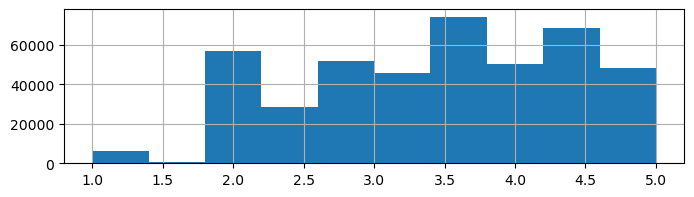

In [34]:
# проверим распределение выборки после заполнения пропусков
train['condition'].hist(figsize=(8,2));
train.loc[train['odometer']<30000, 'condition'].describe().to_frame().transpose()

параметры не изменились

In [35]:
train.loc[(train['odometer']<40000) & (train['odometer']>30000), 'condition'].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
condition,55337.0,3.760945,0.754033,1.0,3.4,3.9,4.3,5.0


In [36]:
train.loc[((train['odometer']<40000) & (train['odometer']>30000) & train['condition'].isna()), 'condition'] = train.loc[
    ((train['odometer']<40000) & (train['odometer']>30000) & train['condition'].isna()), 'condition'].fillna(3.76)

In [37]:
test.loc[((test['odometer']<40000) & (test['odometer']>30000) & test['condition'].isna()), 'condition'] = test.loc[
    ((test['odometer']<40000) & (test['odometer']>30000) & test['condition'].isna()), 'condition'].fillna(3.76)

,count,mean,std,min,25%,50%,75%,max
condition,55626.0,3.76094,0.752071,1.0,3.4,3.9,4.3,5.0


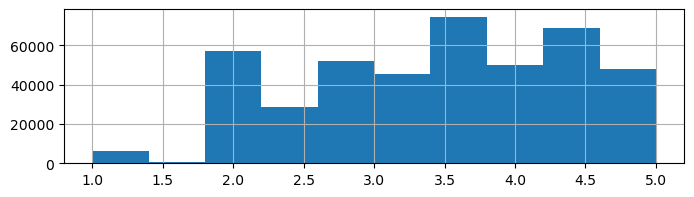

In [38]:
# проверим распределение выборки после заполнения пропусков
train['condition'].hist(figsize=(8,2));
train.loc[(train['odometer']<40000) & (train['odometer']>30000), 'condition'].describe().to_frame().transpose()

In [39]:
train.loc[(train['odometer']>40000) & (train['odometer']<50000), 'condition'].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
condition,37744.0,3.650397,0.76257,1.0,3.2,3.7,4.2,5.0


In [40]:
train.loc[((train['odometer']>40000) & (train['odometer']<50000) & train['condition'].isna()), 'condition'] = train.loc[
    ((train['odometer']>40000) & (train['odometer']<50000) & train['condition'].isna()), 'condition'].fillna(3.65)

In [41]:
test.loc[((train['odometer']>40000) & (test['odometer']<50000) & test['condition'].isna()), 'condition'] = test.loc[
    ((test['odometer']>40000) & (test['odometer']<50000) & test['condition'].isna()), 'condition'].fillna(3.65)

,count,mean,std,min,25%,50%,75%,max
condition,38010.0,3.650395,0.759897,1.0,3.2,3.7,4.2,5.0


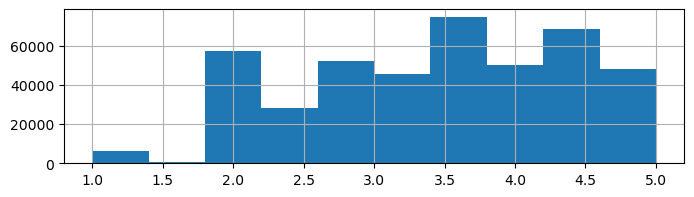

In [42]:
# проверим распределение выборки после заполнения пропусков
train['condition'].hist(figsize=(8,2));
train.loc[((train['odometer']>40000) & (train['odometer']<50000) ), 'condition'].describe().to_frame().transpose()

In [43]:
train.loc[((train['odometer']>50000) & (train['odometer']<60000) ), 'condition'].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
condition,32103.0,3.487708,0.761446,1.0,2.9,3.6,4.1,5.0


In [44]:
train.loc[((train['odometer']>50000) & (train['odometer']<60000) & train['condition'].isna()), 'condition'] = train.loc[
    ((train['odometer']>50000) & (train['odometer']<60000) & train['condition'].isna()), 'condition'].fillna(3.5)

In [45]:
test.loc[((test['odometer']>50000) & (test['odometer']<60000) & test['condition'].isna()), 'condition'] = test.loc[
    ((test['odometer']>50000) & (test['odometer']<60000) & test['condition'].isna()), 'condition'].fillna(3.5)

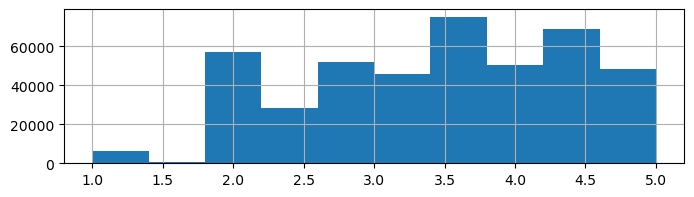

In [46]:
# проверим распределение выборки после заполнения пропусков
train.loc[((train['odometer']>50000) & (train['odometer']<60000) ), 'condition'].describe().to_frame().transpose()
train['condition'].hist(figsize=(8,2));

In [47]:
train.loc[((train['odometer']>60000) & (train['odometer']<80000) ), 'condition'].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
condition,44320.0,3.341519,0.808816,1.0,2.8,3.5,3.9,5.0


In [48]:
train.loc[((train['odometer']>60000) & (train['odometer']<80000) & train['condition'].isna()), 'condition'] = train.loc[
    ((train['odometer']>60000) & (train['odometer']<80000) & train['condition'].isna()), 'condition'].fillna(3.45)

In [49]:
test.loc[((train['odometer']>60000) & (test['odometer']<80000) & test['condition'].isna()), 'condition'] = test.loc[
    ((test['odometer']>60000) & (test['odometer']<80000) & test['condition'].isna()), 'condition'].fillna(3.45)

,count,mean,std,min,25%,50%,75%,max
condition,45102.0,3.343399,0.801899,1.0,2.8,3.5,3.9,5.0


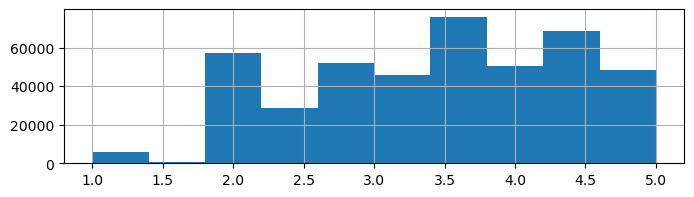

In [50]:
# проверим распределение выборки после заполнения пропусков
train['condition'].hist(figsize=(8,2));
train.loc[((train['odometer']>60000) & (train['odometer']<80000) ), 'condition'].describe().to_frame().transpose()

In [51]:
train.loc[((train['odometer']>80000) & (train['odometer']<100000) ), 'condition'].describe().to_frame().transpose()


,count,mean,std,min,25%,50%,75%,max
condition,39637.0,3.09258,0.829919,1.0,2.4,3.1,3.7,5.0


In [52]:
train.loc[((train['odometer']>80000) & (train['odometer']<100000) & train['condition'].isna()), 'condition'] = train.loc[
    ((train['odometer']>80000) & (train['odometer']<100000) & train['condition'].isna()), 'condition'].fillna(3)

In [53]:
test.loc[((test['odometer']>80000) & (test['odometer']<100000) & test['condition'].isna()), 'condition'] = test.loc[
    ((test['odometer']>80000) & (test['odometer']<100000) & test['condition'].isna()), 'condition'].fillna(3)

,count,mean,std,min,25%,50%,75%,max
condition,40894.0,3.089734,0.817221,1.0,2.5,3.0,3.7,5.0


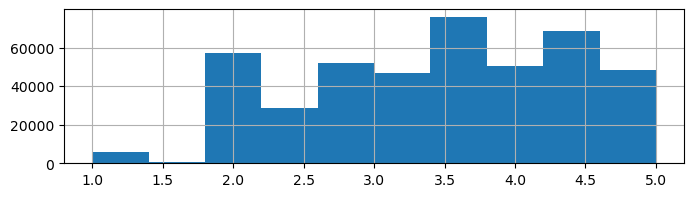

In [54]:
# проверим распределение выборки после заполнения пропусков
train['condition'].hist(figsize=(8,2));
train.loc[((train['odometer']>80000) & (train['odometer']<100000) ), 'condition'].describe().to_frame().transpose()

In [55]:
train.loc[((train['odometer']>100000) & (train['odometer']<150000) ), 'condition'].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
condition,67842.0,2.740674,0.792235,1.0,2.0,2.7,3.4,5.0


In [56]:
train.loc[((train['odometer']>100000) & (train['odometer']<150000) & train['condition'].isna()), 'condition'] = train.loc[
    ((train['odometer']>100000) & (train['odometer']<150000) & train['condition'].isna()), 'condition'].fillna(2.7)

In [57]:
test.loc[((test['odometer']>100000) & (test['odometer']<150000) & test['condition'].isna()), 'condition'] = test.loc[
    ((test['odometer']>100000) & (test['odometer']<150000) & test['condition'].isna()), 'condition'].fillna(2.7)

,count,mean,std,min,25%,50%,75%,max
condition,71213.0,2.738749,0.773304,1.0,2.0,2.7,3.4,5.0


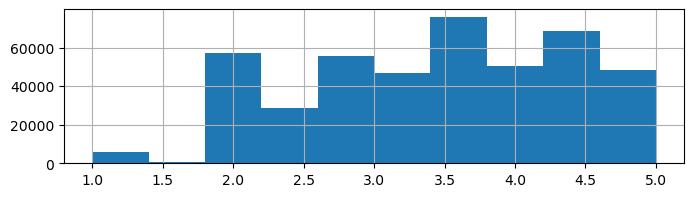

In [58]:
# проверим распределение выборки после заполнения пропусков
train['condition'].hist(figsize=(8,2));
train.loc[((train['odometer']>100000) & (train['odometer']<150000) ), 'condition'].describe().to_frame().transpose()

In [59]:
train['condition'].isna().sum()

2531

 Дальше заполнять по этому принципу не вижу смысла, так как уже разбег очень сильный в значениях, учитывая, что машины с пробегом после 150 тыс это уже редкие значения.

In [60]:
train[['odometer']].quantile([0.02,0.05, 0.1, .5, .65, .75, .85, .93, .99]).transpose()

,0.02,0.05,0.10,0.50,0.65,0.75,0.85,0.93,0.99
odometer,5856.32,10475.0,15616.0,52098.0,77689.9,99272.0,125266.0,157501.38,226987.68


In [61]:
train['condition'].fillna(-999, inplace=True)
train['condition'].isna().sum()

0

In [62]:
test['condition'].fillna(-999, inplace=True)
test['condition'].isna().sum()

0

**YEAR**

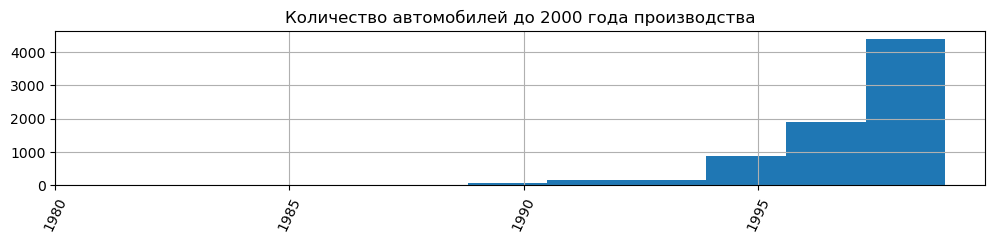

In [63]:
train.loc[train['year']<2000,'year'].hist(figsize=(12,2))
plt.xticks([j/5 for j in range(9900, 10000, 25)], rotation=65)
plt.title('Количество автомобилей до 2000 года производства');

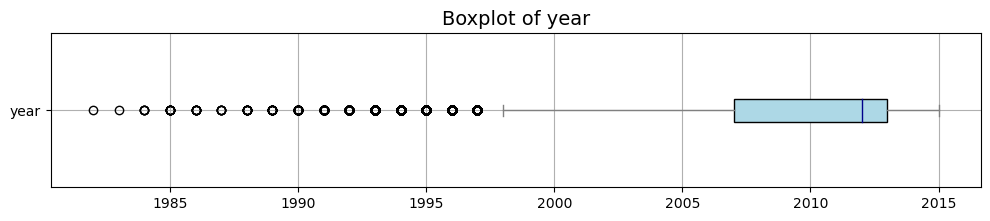

In [64]:
train.boxplot(column=['year'], figsize=(12, 2),
             vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            whiskerprops=dict(color='gray'),
            medianprops=dict(color='darkblue'),
            capprops=dict(color='gray')).set_title('Boxplot of year', fontsize=14);

In [65]:
train[['year']].quantile([0.02,0.05, 0.1, .5, .65, .75, .85, .9, .99]).transpose()


,0.02,0.05,0.10,0.50,0.65,0.75,0.85,0.90,0.99
year,2000.0,2002.0,2004.0,2012.0,2012.0,2013.0,2014.0,2014.0,2015.0


In [66]:
test[['year']].quantile([0.02,0.05, 0.1, .5, .65, .75, .85, .9, .99]).transpose()


,0.02,0.05,0.10,0.50,0.65,0.75,0.85,0.90,0.99
year,2000.0,2002.0,2004.0,2012.0,2012.0,2013.0,2014.0,2014.0,2015.0


Видим, что в данных есть около 2% автомобилей до 2000 года производства. 

**ODOMETER**

In [67]:
# проанализируем признак odometer
train['odometer'].head()

0    111041.0
1     31034.0
2     35619.0
3    131301.0
4    127709.0
Name: odometer, dtype: float64

Этот признак содержит данные о пробеге автомобилей.
Чтобы было удобнее работать с этим признаком разделим все значения на 1000. 

In [68]:
train['odometer'] = train['odometer']/1000
train['odometer'].head()

0    111.041
1     31.034
2     35.619
3    131.301
4    127.709
Name: odometer, dtype: float64

In [69]:
test['odometer'] = test['odometer']/1000
test['odometer'].head()

0    116.970
1      6.286
2     11.831
3     57.105
4     31.083
Name: odometer, dtype: float64

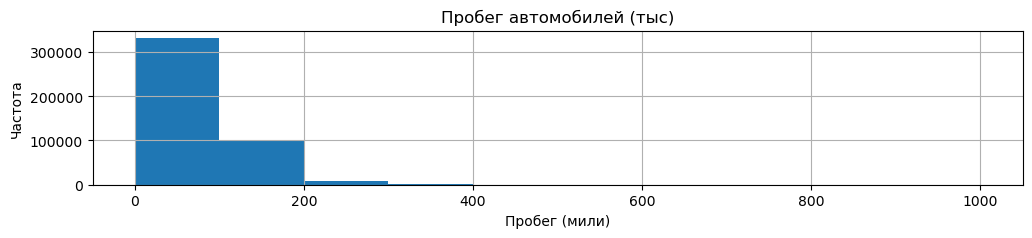

In [70]:
train['odometer'].hist(figsize=(12, 2))
plt.title('Пробег автомобилей (тыс)')
plt.xlabel('Пробег (мили)')
plt.ylabel('Частота')
plt.show()


На графике видно, что основная масса автомобилей имеет пробег до 200 тыс, проанализируем количество автомобилей с пробегом более 200 тыс.

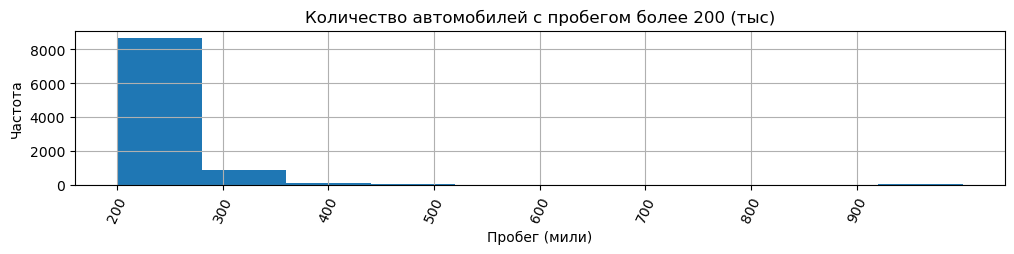

In [71]:
# построим гистограмму для распределения количества автомобилей с пробегом от 200 тыс
train.loc[train['odometer']>200, 'odometer'].hist(figsize=(12, 2))
plt.xticks([j for j in range(200, 1000, 100)], rotation=65)
plt.title('Количество автомобилей с пробегом более 200 (тыс)')
plt.xlabel('Пробег (мили)')
plt.ylabel('Частота')
plt.show()


In [72]:
train[['odometer']].quantile([0.02,0.05,0.5,.65, .75, .85, .9, .9825, .99]).transpose()


,0.0200,0.0500,0.5000,0.6500,0.7500,0.8500,0.9000,0.9825,0.9900
odometer,5.85632,10.475,52.098,77.6899,99.272,125.266,143.186,207.879475,226.98768


In [73]:
test[['odometer']].quantile([0.02,0.05,0.5, .65, .75, .85, .9, .9825, .99]).transpose()

,0.0200,0.0500,0.5000,0.6500,0.7500,0.8500,0.9000,0.9825,0.9900
odometer,5.878,10.519,51.922,77.2082,98.8525,124.3126,142.5648,206.715335,226.68594


Лишь менее 2 процентов автомобилей имеют пробег более 200 тыс., это очень редкие значения, но учитывая что не можем их удалить, мы оставим эти данные.

Пробег менее 5 тыс километров так же редко встречается, и  это вполне логичное явление для автомобилей, со свежим сроком выпуска.

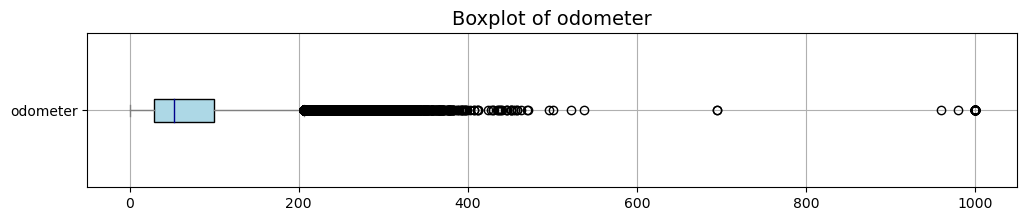

In [74]:
train.boxplot(column=['odometer'], figsize=(12, 2),
             vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            whiskerprops=dict(color='gray'),
            medianprops=dict(color='darkblue'),
            capprops=dict(color='gray')).set_title('Boxplot of odometer', fontsize=14);

In [75]:
#заполним пропуски заглушкой
train['odometer'].fillna(-999, inplace=True)
test['odometer'].fillna(-999, inplace=True)
print ('Количество пропущенных значений в odometer:')
print ('train', train['odometer'].isna().sum())
print ('test',test['odometer'].isna().sum())

Количество пропущенных значений в odometer:
train 0
test 0


**Проанализируем категориальные признаки**

In [76]:
train[cat_features].head(10)

,make,model,trim,body,transmission,state,color,interior,seller
0,Ford,Edge,SEL,suv,automatic,md,black,black,santander consumer
1,Ford,Fusion,SE,Sedan,automatic,mo,black,black,ars/avis budget group
2,Nissan,Sentra,2.0 SL,sedan,automatic,nj,black,black,nissan-infiniti lt
3,HUMMER,H2,Base,suv,automatic,tx,gold,beige,wichita falls ford lin inc
4,Ford,Fusion,SEL,Sedan,automatic,md,black,black,purple heart
5,Lincoln,MKZ,Base,Sedan,automatic,mi,black,black,"ford motor credit company,llc"
6,pontiac,g6,4c,no_info,automatic,nc,silver,black,north state acceptance
7,Ford,Escape,SE,SUV,automatic,fl,blue,gray,fields bmw
8,Hyundai,Elantra,GLS,Sedan,automatic,oh,black,tan,dt inventory
9,Ford,Freestyle,Limited,wagon,automatic,oh,black,tan,wells fargo dealer services


В категориальных признаках мы видим следующие проблемы:
- разный регистр;
- пробелы;
- разные знаки внутри слов;
- цифры написаны слитно со словами.


In [77]:
for column in cat_features:
    print (column, train[column].nunique())
    print ()

make 93

model 960

trim 1923

body 86

transmission 3

state 38

color 21

interior 18

seller 13025



In [78]:
for column in cat_features:
    print (column, test[column].nunique())
    print ()

make 86

model 825

trim 1497

body 78

transmission 3

state 38

color 21

interior 18

seller 7623



In [79]:
def transform_values(df):
    # заменяем пробелы на underscore 
    df = df.applymap(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)
    
    # заменяем дефис на underscore
    df = df.applymap(lambda x: x.replace('-', '_') if isinstance(x, str) else x)
    
    # добавляем underscore между словом и цислом
    df = df.applymap(lambda x: '_'.join(part for part in x.split() if not part.isdigit()) if isinstance(x, str) else x)
    # приводим к строчному регистру
    df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
    
    return df

In [80]:
train = transform_values(train)
train.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,sale_year,sale_month
0,2011,ford,edge,sel,suv,automatic,md,4.2,111.041,black,black,santander_consumer,12500,2015,6
1,2014,ford,fusion,se,sedan,automatic,mo,3.5,31.034,black,black,ars/avis_budget_group,14500,2015,2
2,2012,nissan,sentra,2.0_sl,sedan,automatic,nj,2.2,35.619,black,black,nissan_infiniti_lt,9100,2015,6
3,2003,hummer,h2,base,suv,automatic,tx,2.8,131.301,gold,beige,wichita_falls_ford_lin_inc,13300,2015,6
4,2007,ford,fusion,sel,sedan,automatic,md,2.0,127.709,black,black,purple_heart,1300,2015,2


In [81]:
for column in cat_features:
    print (column, train[column].nunique())
    print ()

make 63

model 827

trim 1832

body 45

transmission 3

state 38

color 21

interior 18

seller 13018



In [82]:
test = transform_values(test)
test.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sale_year,sale_month
0,2005,cadillac,cts,base,sedan,automatic,ca,2.7,116.970,silver,black,lexus_of_stevens_creek,2015,1
1,2014,gmc,savana_cargo,,van,no_info,pa,4.4,6.286,white,gray,u_haul,2015,2
2,2013,nissan,murano,s,suv,automatic,oh,4.6,11.831,gray,black,nissan_infiniti_lt,2015,2
3,2013,chevrolet,impala,ls_fleet,sedan,automatic,fl,2.3,57.105,silver,black,onemain_rem/auto_club_of_miami_inc_dba_north_dad,2015,3
4,2013,nissan,titan,sv,crew_cab,automatic,tn,2.9,31.083,black,black,nissan_north_america_inc.,2015,6


In [83]:
for column in cat_features:
    print (column, test[column].nunique())
    print ()

make 59

model 734

trim 1446

body 42

transmission 3

state 38

color 21

interior 18

seller 7619



In [84]:
train['make'].nunique()

63

In [85]:
train['make'] = train['make'].replace({'mercedes_benz': 'mercedes', 
                                       'mercedes_b': 'mercedes', 
                                       'vw': 'volkswagen',
                                      'land_rover':'landrover',
                                      'ford_truck':'ford',
                                      'mazda_tk':'mazda',
                                      'dodge_tk':'dodge',
                                      'gmc_truck':'gmc',
                                      'hyundai_tk':'hyundai',
                                     'ford_tk':'ford'})
print (train['make'].nunique())

55


In [86]:
test['make'].nunique()

59

In [87]:
test['make'] = test['make'].replace({'mercedes_benz': 'mercedes', 
                                       'mercedes_b': 'mercedes', 
                                       'vw': 'volkswagen',
                                      'land_rover':'landrover',
                                      'ford_truck':'ford',
                                      'mazda_tk':'mazda',
                                      'dodge_tk':'dodge',
                                      'gmc_truck':'gmc',
                                      'hyundai_tk':'hyundai',
                                     'ford_tk':'ford'})
print (test['make'].nunique())

54


**Посмотрим какие модели встречаются чаще всего**

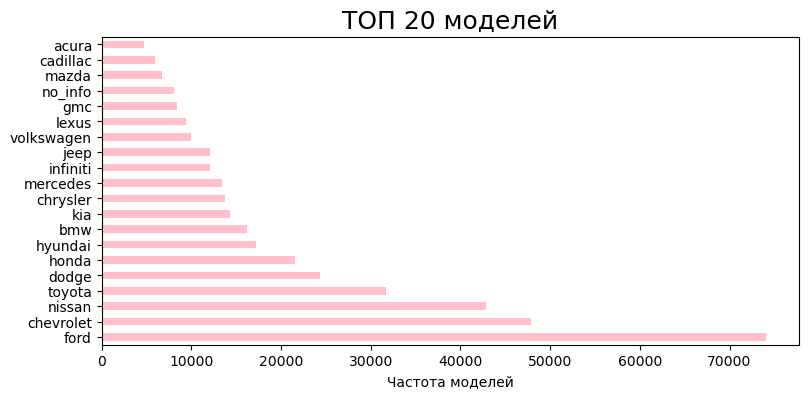

In [88]:
plt.figure(figsize=(9,4))
train['make'].value_counts().nlargest(20).plot(kind='barh', color = 'pink')
plt.xlabel('Частота моделей')
plt.title("TOП 20 моделей",fontsize=18)
plt.show()

Почистим от неявных дубликатов самые распространенные марки.

In [89]:
for make in train['make'].unique():
    print(make,
          train.loc[train['make']==make, 'model'].nunique(), 
          train.loc[train['make']==make, 'model'].unique())
    print()

ford 64 ['edge' 'fusion' 'escape' 'freestyle' 'windstar' 'taurus' 'explorer'
 'f_150' 'flex' 'mustang' 'expedition' 'five_hundred' 'e_series_van'
 'focus' 'fusion_hybrid' 'explorer_sport_trac' 'f_250_super_duty' 'ranger'
 'fiesta' 'f_350_super_duty' 'f150' 'crown_victoria' 'e_series_wagon'
 'freestar' 'transit_connect' 'econoline_cargo' 'f_450_super_duty'
 'expedition_el' 'escort' 'c_max_hybrid' 'c_max_energi' 'escape_hybrid'
 'shelby_gt500' 'explorer_sport' 'taurus_x' 'expeditn' 'excursion'
 'econoline_wagon' 'fusion_energi' 'mustang_svt_cobra' 'f_150_heritage'
 'police' 'focus_st' 'thunderbird' 'e350' 'e150' 'excurs' 'e'
 'transit_van' 'crown' 'contour' 'e_250' 'e_150' 'transit_wagon' 'e250'
 'f250' 'windstar_cargo' 'f_150_svt_lightning' 'f350' 'expedit' 'tempo'
 'e_350' 'aspire' 'f_250']

nissan 31 ['sentra' 'murano' 'armada' 'altima' 'rogue' 'maxima' 'versa' 'pathfinder'
 'cube' 'rogue_select' 'frontier' '370z' 'quest' 'leaf' 'titan' 'xterra'
 'nv_cargo' 'juke' 'altima_hybrid' '350

In [90]:
# удалим неявные дубликаты
train['model'] = train['model'].replace({'mountnr': 'mountaineer', 
                                       'mazdaspeed_mazda3': 'mazdaspeed3',
                                      'mazdaspeed_mx_5_miata':'mx_5_miata',
                                      'e150':'e_150',
                                      'f150':'f_150',
                                      'e350':'e_350',
                                      'e250':'e_250',
                                          'expeditn': 'expedition',
                                         'expedit': 'expedition',
                                        'crown': 'crown_victoria',
                                         'excurs' : 'excursion',
                                         'e150' : 'e_150',
                                         'e250':'e_250'  ,
                                         'e350' :  'e_350' ,
                                         'f250':'f_250',
                                          'f150':'f_150',
                                         'f350':'f_350',
                                        'subrbn':'suburban',
                                        'e':'e_series',
                                        'silverado_2500':'silverado_2500hd',
                                         'silverado_3500': 'silverado_3500hd',
                                       'capt':'captiva',
                                       'uplandr':'uplander',
                                       's10':'s_10'})

In [91]:
test['model'] = test['model'].replace({'mountnr': 'mountaineer', 
                                       'mazdaspeed_mazda3': 'mazdaspeed3',
                                      'mazdaspeed_mx_5_miata':'mx_5_miata',
                                      'e150':'e_150',
                                      'f150':'f_150',
                                      'e350':'e_350',
                                      'e250':'e_250',
                                          'expeditn': 'expedition',
                                         'expedit': 'expedition',
                                        'crown': 'crown_victoria',
                                         'excurs' : 'excursion',
                                         'e150' : 'e_150',
                                         'e250':'e_250'  ,
                                         'e350' :  'e_350' ,
                                         'f250':'f_250',
                                          'f150':'f_150',
                                         'f350':'f_350',
                                        'subrbn':'suburban',
                                        'e':'e_series',
                                       'silverado_2500':'silverado_2500hd',
                                         'silverado_3500': 'silverado_3500hd',
                                       'capt':'captiva',
                                       'uplandr':'uplander',
                                       's10':'s_10'
                                      })

In [92]:
for make in train['make'].unique():
    print(make,
          train.loc[train['make']==make, 'model'].nunique())
    print()

ford 55

nissan 31

hummer 5

lincoln 17

pontiac 19

hyundai 21

no_info 1

buick 14

chevrolet 66

honda 18

acura 14

cadillac 23

gmc 29

saab 4

dodge 29

mercedes 37

toyota 31

volkswagen 24

bmw 41

infiniti 35

chrysler 19

kia 14

jaguar 8

subaru 11

jeep 9

lexus 39

scion 6

fiat 3

suzuki 14

mazda 26

volvo 16

audi 27

mini 6

isuzu 7

mitsubishi 16

smart 2

porsche 8

landrover 13

saturn 12

ram 6

oldsmobile 12

mercury 15

bentley 8

fisker 1

maserati 7

tesla 1

rolls_royce 1

ferrari 3

plymouth 5

lamborghini 1

geo 2

aston_martin 3

daewoo 1

dot 1

airstream 1



**color**

In [93]:
train['color'].value_counts()

black        87115
white        84149
silver       65667
gray         65284
blue         40237
red          34514
—            19520
green         8975
gold          8934
beige         7257
burgundy      7059
brown         5320
orange        1629
purple        1250
off_white     1143
yellow         979
no_info        586
charcoal       389
turquoise      183
pink            32
lime            14
Name: color, dtype: int64

Пробовала уменьшить количество категорий в признаке, добавив признак other, но модель потеряла 0.3 

**body**

In [94]:
train['body'].value_counts().sort_index().index

Index(['access_cab', 'beetle_convertible', 'cab_plus', 'cab_plus_4',
       'club_cab', 'convertible', 'coupe', 'crew_cab', 'crewmax_cab',
       'cts_coupe', 'cts_v_coupe', 'cts_v_wagon', 'cts_wagon', 'double_cab',
       'e_series_van', 'elantra_coupe', 'extended_cab', 'g37_convertible',
       'g37_coupe', 'g_convertible', 'g_coupe', 'g_sedan', 'genesis_coupe',
       'granturismo_convertible', 'hatchback', 'king_cab', 'koup', 'mega_cab',
       'minivan', 'no_info', 'promaster_cargo_van', 'q60_convertible',
       'q60_coupe', 'quad_cab', 'ram_van', 'regular_cab', 'sedan', 'supercab',
       'supercrew', 'suv', 'transit_van', 'tsx_sport_wagon', 'van', 'wagon',
       'xtracab'],
      dtype='object')

In [95]:
test['body'].value_counts().sort_index().index

Index(['access_cab', 'beetle_convertible', 'cab_plus', 'club_cab',
       'convertible', 'coupe', 'crew_cab', 'crewmax_cab', 'cts_coupe',
       'cts_v_coupe', 'cts_wagon', 'double_cab', 'e_series_van',
       'elantra_coupe', 'extended_cab', 'g37_convertible', 'g37_coupe',
       'g_convertible', 'g_coupe', 'g_sedan', 'genesis_coupe',
       'granturismo_convertible', 'hatchback', 'king_cab', 'koup', 'mega_cab',
       'minivan', 'no_info', 'promaster_cargo_van', 'q60_convertible',
       'q60_coupe', 'quad_cab', 'regular_cab', 'sedan', 'supercab',
       'supercrew', 'suv', 'transit_van', 'tsx_sport_wagon', 'van', 'wagon',
       'xtracab'],
      dtype='object')

Дубликатов не наблюдается.

In [96]:
list(train.columns)

['year',
 'make',
 'model',
 'trim',
 'body',
 'transmission',
 'state',
 'condition',
 'odometer',
 'color',
 'interior',
 'seller',
 'sellingprice',
 'sale_year',
 'sale_month']

# Модели

In [97]:
#Разделим выборки
train_data, validation = train_test_split(train, random_state=42)
print(train_data.shape[0])
print(validation.shape[0])

330177
110059


In [98]:
#выделим обучающие признаки и целевой признак
X = ['year', 'make', 'model', 'trim', 'body', 'transmission', 'state','condition', 'odometer', 'color',
     'interior', 'seller', 'sale_year','sale_month']
y = ['sellingprice']

In [99]:
train_pool = Pool(data=train_data[X], 
                  label=train_data[y], 
                  cat_features=cat_features)
print(train_pool.shape[0])

330177


In [100]:
validation_pool = Pool(data=validation[X],
                       label=validation[y], 
                  cat_features=cat_features)
print(validation_pool.shape[0])

110059


## RandomGridSearch

In [101]:
# параметры для перебора
param_grid = {
    'learning_rate': [0.01, 0.15],
    'depth': [6, 15],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

In [102]:
params = {
    'cat_features': cat_features,
    'eval_metric': 'MAPE',
    'loss_function': 'RMSE',
    'random_seed': 42,
    'verbose': 100,
    'early_stopping_rounds':100
}

In [103]:
#инициализируем модель
model = CatBoostRegressor(**params)

In [104]:
now = datetime.datetime.now()

print(now)

2023-06-04 19:38:23.656729


In [105]:
%%time
randomized_search_result = model.randomized_search(param_grid,
                                                   train_pool)
print (model.best_score_)

0:	learn: 0.8373241	test: 0.8121312	best: 0.8121312 (0)	total: 499ms	remaining: 8m 18s
100:	learn: 0.2995472	test: 0.2271547	best: 0.2271547 (100)	total: 32.9s	remaining: 4m 53s
200:	learn: 0.2630608	test: 0.2079058	best: 0.2079058 (200)	total: 1m 5s	remaining: 4m 21s
300:	learn: 0.2484287	test: 0.1963799	best: 0.1963799 (300)	total: 1m 39s	remaining: 3m 50s
400:	learn: 0.2368322	test: 0.1906531	best: 0.1906531 (400)	total: 2m 11s	remaining: 3m 16s
500:	learn: 0.2333053	test: 0.1853446	best: 0.1853444 (498)	total: 2m 45s	remaining: 2m 45s
600:	learn: 0.2253220	test: 0.1821461	best: 0.1821461 (600)	total: 3m 18s	remaining: 2m 11s
700:	learn: 0.2234953	test: 0.1805600	best: 0.1805426 (691)	total: 3m 52s	remaining: 1m 39s
800:	learn: 0.2163615	test: 0.1773843	best: 0.1773843 (800)	total: 4m 25s	remaining: 1m 6s
900:	learn: 0.2117910	test: 0.1754574	best: 0.1754574 (900)	total: 5m	remaining: 33s
999:	learn: 0.2086029	test: 0.1738891	best: 0.1738891 (999)	total: 5m 32s	remaining: 0us

bestT

In [106]:
best_params = randomized_search_result['params']
best_params

{'depth': 15, 'l2_leaf_reg': 7, 'learning_rate': 0.15}

In [107]:
# оцениваем
y_pred = model.predict(validation_pool)

In [108]:
rmse = mean_squared_error(validation[y], y_pred, squared=False)

#  MAPE
mape = mean_absolute_percentage_error(validation[y], y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}")

Root Mean Squared Error (RMSE): 2210.176
Mean Absolute Percentage Error (MAPE): 0.154


best_params = {'depth': 9,
               'iterations': 3000, 
               'learning_rate': 0.07555198107934782, 
               'l2_leaf_reg': 8.206677907347204,
               'cat_features': cat_features,
    'eval_metric': 'MAPE',
    'loss_function': 'RMSE',
    'random_seed': 42,
    'verbose': False,
    'early_stopping_rounds' : 15}

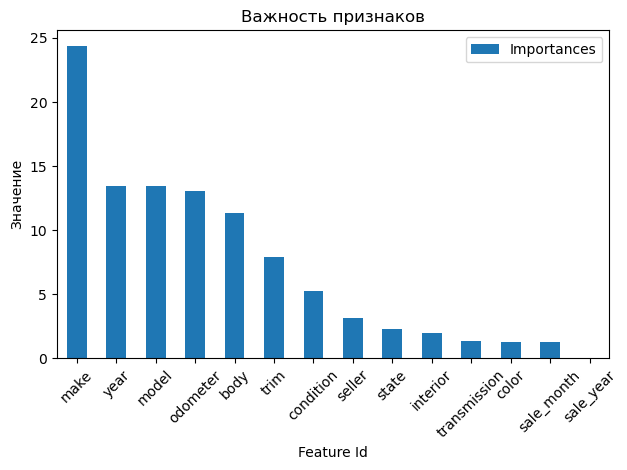

In [109]:
fstrs = model.get_feature_importance(prettified=True)

fig, ax = plt.subplots()
fstrs.plot(x='Feature Id', y='Importances', kind='bar', ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel("Значение")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [110]:
best_model = CatBoostRegressor(**best_params,
                               random_seed= 42,
                              verbose = 100)

In [112]:
train_pool = Pool(data=train[X], 
                  label=train[y], 
                  cat_features=cat_features)
print(train_pool.shape[0])

440236


In [ ]:
%%time
# обучаем модель
best_model.fit(train_pool)
print (best_model.best_score_)

0:	learn: 8695.0652600	total: 3.62s	remaining: 1h 11s
100:	learn: 2042.5373245	total: 5m 17s	remaining: 47m 4s
200:	learn: 1666.2917970	total: 10m 43s	remaining: 42m 39s
300:	learn: 1454.9802321	total: 16m 17s	remaining: 37m 50s
500:	learn: 1186.1745310	total: 27m 22s	remaining: 27m 15s
600:	learn: 1091.2067724	total: 33m	remaining: 21m 55s
700:	learn: 999.7179941	total: 38m 50s	remaining: 16m 33s
800:	learn: 922.0698332	total: 44m 29s	remaining: 11m 3s
900:	learn: 855.5911865	total: 50m 3s	remaining: 5m 30s


In [ ]:
y_pred_test = model.predict(test[X])
y_pred_test

In [ ]:
test_vin = pd.read_csv('/kaggle/input/copy-of-used-cars-price-prediction-ds18/test.csv')
test_vin['vin'].head()

In [ ]:
prediction = pd.DataFrame()
prediction.head()

In [ ]:
prediction['vin']=test_vin['vin']
prediction.head()

In [ ]:
prediction['sellingprice']=y_pred_test
prediction.head()

In [ ]:
prediction.loc[prediction['sellingprice']<250, 'sellingprice']=250
prediction.loc[prediction['sellingprice']<250].shape[0]

In [ ]:
prediction.to_csv('result_10.csv', index = False)

In [ ]:
then = datetime.datetime.now()

print('Начало выполнения',now)
 print('Конец выполнения', then) 